In [1]:
import pickle 
import pandas as pd
import numpy as np
from sklearn import metrics

my_data = pd.read_pickle("6log_signature_1cyclePerSec_2015_weeks_8_9")

#select features
#top features
#choose top 26 features from the random forest model
features = [9,4,60,7,10,42,17,5,23,25,29,51,2,11,15,18,22,30,39,41,44,46,52,54,57,66]
#features = 1 + np.arange(my_data.shape[1] - 2)

X, y = my_data[features], my_data[196]
X = X*100

breakpoint1 = int(0.6 * my_data.shape[0])
breakpoint2 = int(0.8 * my_data.shape[0])

X_train, X_dev, X_test = X[:breakpoint1], X[breakpoint1:breakpoint2], X[breakpoint2:]
y_train, y_dev, y_test = y[:breakpoint1], y[breakpoint1:breakpoint2], y[breakpoint2:]

print(X_train.shape, X_dev.shape,X_test.shape)
print(y_train.shape, y_dev.shape, y_test.shape)

(741522, 26) (247174, 26) (247175, 26)
(741522,) (247174,) (247175,)


In [2]:
#modif data using (overlapping is optional) windows of length precision
#precision is the number of seconds, or timestamps to be more precise
#this is only to tune parameters in the CNN
def modified_data(precision, window, X):
    t = len(range(0,X.shape[0] - window, precision))
    u = len(np.array(X.iloc[0:0+window]))
    modified_data = np.empty((t,window, len(features)))
    count = 0
    for k in range(0, X.shape[0] - window, precision):
        modified_data[count] = np.array(X.iloc[k:k+window])
        count = count + 1   
    return modified_data

def modified_labels(precision, window, y):
    new_labels = np.empty(len(range(0,y.shape[0] - window, precision)))
    count = 0
    for k in range(0, y.shape[0] - window, precision):
        ones = sum(y[k:k+window])
        if ones == window:
            new_labels[count] = 1
        else:
            new_labels[count] = 0
        count = count + 1
    return new_labels

#precision = 21
#window = 42
#new_train = modified_data(precision, window, X_train)
#new_dev = modified_data(precision, window, X_dev)
#label_train = modified_labels(precision, window, y_train)
#label_dev = modified_labels(precision, window, y_dev)
#print(new_train.shape, label_train.shape)
#print(new_dev.shape, label_dev.shape)

In [ ]:
#this breakpoint is for test data in the CNN
#break_CNN1 = int(0.6 * new_data.shape[0])
#break_CNN2 = int(0.8 * new_data.shape[0])

#this breakpoint is for using in segmentation "in_character" function
#break_segm = int(0.8 * my_data.shape[0])

In [ ]:
#prepare precision length windows for CNN  
#x_train, x_test = new_data[:break_CNN], new_data[break_CNN:]
#y_train, y_test = new_labels[:break_CNN], new_labels[break_CNN:]
#print(x_train.shape, x_test.shape)
#print(y_train.shape, y_test.shape)

In [3]:
#import necessary for CNN
import statistics
from statistics import mean
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import AveragePooling1D

# Train on intervals of different lengths

In [4]:
windows = [43, 85, 169, 338, 675, 1350, 2700, 5400, 10800]
def model(window):
    precision = 21
    stride = 1
    new_train = modified_data(precision, window, X_train)
    new_dev = modified_data(precision, window, X_dev)
    label_train = modified_labels(precision, window, y_train)
    label_dev = modified_labels(precision, window, y_dev)
    kernel_size = 5
    
    print(new_train.shape, label_train.shape)
    print(new_dev.shape, label_dev.shape)
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=kernel_size, strides = stride, activation='relu', input_shape=(window, 26)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation ='sigmoid'))
    print(model.summary())
    #model.compile(optimizer='adam', loss='mse')
    sgd = SGD(lr = 0.01, momentum = 0.9, decay = 0, nesterov = False)
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    model.fit(new_train, label_train, batch_size = 100, epochs = 150, verbose = 0)
    #model.summary()

    label_dev = 1-label_dev
    label_train=1-label_train
    
    y_pred_dev = model.predict(new_dev)
    y_pred_dev = y_pred_dev.reshape(y_pred_dev.shape[0])
    y_pred_dev = np.array(y_pred_dev)
    y_pred_dev = 1 - y_pred_dev
    #y_pred_dev = np.array(y_pred_dev > 0.5)
    
    
        
    from sklearn import metrics
    #print(str(window)+ ": ")
    #print("Accuracy for test:",metrics.accuracy_score(label_dev, y_pred_dev))
    #print("Accuracy for train:",metrics.accuracy_score(label_train, y_pred_train))
    #print("---")
    
    return (y_pred_dev, label_dev)

        

In [26]:
%%time
(y_pred_dev, label_dev) = model(42)

(35309, 42, 26) (35309,)
(11769, 42, 26) (11769,)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 38, 64)            8384      
_________________________________________________________________
average_pooling1d_9 (Average (None, 19, 64)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1217      
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 7min 30s, sys: 41.2 s, total: 8min 11s
Wall time: 2min 1s


In [38]:
print(y_pred_dev)
print(label_dev)

[0.48454595 0.26852953 0.13356853 ... 0.00486463 0.00561243 0.00388998]
[1. 1. 0. ... 0. 0. 0.]


# Compute ROC curve

In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr2, tpr2, thresholds2 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr3, tpr3, thresholds3 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr4, tpr4, thresholds4 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr5, tpr5, thresholds5 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr6, tpr6, thresholds6 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr7, tpr7, thresholds7 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr8, tpr8, thresholds8 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr9, tpr9, thresholds9 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

In [27]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr10, tpr10, thresholds10 = metrics.roc_curve(label_dev, y_pred_dev, pos_label=1)

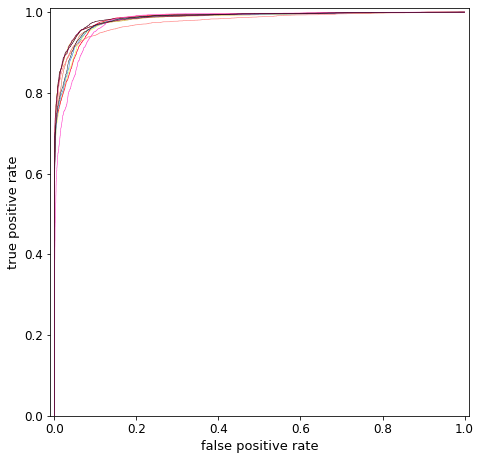

<Figure size 432x288 with 0 Axes>

In [28]:
from pathlib import Path
from matplotlib.pyplot import figure, draw
from matplotlib import pyplot as plt
fn = Path('/Users/mihaithpc/Desktop/svg_figures_dale/rocCNN.svg').expanduser()


fig, ax = plt.subplots(figsize=(7.5,7.5))
#ax.scatter(fpr[::100][:9], tpr[::100][:9], c='blue')
#ax.scatter(fpr[::100][10:], tpr[::100][10:], c='blue')
ax.plot(fpr, tpr, c=(0.9,0.5,0.4), linewidth = 0.6)
ax.plot(fpr2, tpr2, c=(0.9,1,0.4), linewidth = 0.6)
ax.plot(fpr3, tpr3, c=(1,0,0.2), linewidth = 0.6)
ax.plot(fpr4, tpr4, c=(0.8, 0.7,0.2), linewidth = 0.6)
ax.plot(fpr5, tpr5, c=(0.3,0.6,0.9), linewidth = 0.6)
ax.plot(fpr6, tpr6, c=(0.3,0,0.1), linewidth = 0.6)
ax.plot(fpr7, tpr7, c=(1,0.5,0.5), linewidth = 0.6)        
ax.plot(fpr8, tpr8, c=(1,0.3,0.8), linewidth = 0.6)        
ax.plot(fpr9, tpr9, c=(0.5,0,0.3), linewidth = 0.6)       
ax.plot(fpr10, tpr10, c=(0,0,0), linewidth = 0.4)        
        
ax.set_xlabel("false positive rate", fontsize=13)
ax.set_ylabel("true positive rate",fontsize=13)
#ax.plot((0.037, 0.037), (0,0.917), 'k')
#ax.plot((0, 0.037), (0.917, 0.917), 'k')
ax.set_xlim([-0.01,1.01])
ax.set_ylim([0,1.01])
ax.tick_params(labelsize='large')
#ax.annotate("0.5", (0.065, 0.95))
#ax.annotate("0.74", (0.037, 0.917))
#plt.xticks([0, 0.037, 0.065, 0.2, 0.4, 0.6, 0.8, 1])
#plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 0.917,  0.9386, 1])
#for i, txt in enumerate(np.around(thresholds[::150], 3)):
    #ax.annotate(txt, (fpr[i*150], tpr[i*150]))
plt.show()


draw() # necessary to render figure before saving
fig.savefig(fn, bbox_inches='tight')



In [25]:
fpr9

array([0.        , 0.        , 0.        , ..., 0.99565933, 0.99595869,
       1.        ])

In [88]:
print(np.where(thresholds>0.49))
print(np.where(thresholds<0.51))
print('--------')
print(np.where(thresholds10>0.49))
print(np.where(thresholds10<0.51))
print('--------')
print(np.where(thresholds2>0.49))
print(np.where(thresholds2<0.51))
print('--------')
print(np.where(thresholds3>0.49))
print(np.where(thresholds3<0.51))
print('--------')
print(np.where(thresholds4>0.49))
print(np.where(thresholds4<0.51))
print('--------')
print(np.where(thresholds5>0.49))
print(np.where(thresholds5<0.51))
print('--------')
print(np.where(thresholds6>0.49))
print(np.where(thresholds6<0.51))
print('--------')
print(np.where(thresholds7>0.49))
print(np.where(thresholds7<0.51))
print('--------')
print(np.where(thresholds8>0.49))
print(np.where(thresholds8<0.51))
print('--------')
print(np.where(thresholds9>0.49))
print(np.where(thresholds9<0.51))
print('--------')

(array([   0,    1,    2, ..., 1126, 1127, 1128]),)
(array([1117, 1118, 1119, ..., 2828, 2829, 2830]),)
--------
(array([   0,    1,    2, ..., 1069, 1070, 1071]),)
(array([1064, 1065, 1066, ..., 2173, 2174, 2175]),)
--------
(array([   0,    1,    2, ..., 1171, 1172, 1173]),)
(array([1161, 1162, 1163, ..., 2779, 2780, 2781]),)
--------
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 

In [91]:
print(tpr[1125])
print(fpr[1125])
print('-------')
print(tpr2[1066])
print(fpr2[1066])
print('-------')
print(tpr3[1170])
print(fpr3[1170])
print('-------')
print(tpr4[915])
print(fpr4[915])
print('-------')
print(tpr5[960])
print(fpr5[960])
print('-------')
print(tpr6[1045])
print(fpr6[1045])
print('-------')
print(tpr7[1120])
print(fpr7[1120])
print('-------')
print(tpr8[980])
print(fpr8[980])
print('-------')
print(tpr9[920])
print(fpr9[920])
print('-------')
print(tpr10[1015])
print(fpr10[1015])
print('-------')

0.88187893081761
0.052537045352492144
-------
0.8604559748427673
0.04744798682831911
-------
0.9147012578616353
0.07124681933842239
-------
0.877751572327044
0.038317617123185155
-------
0.8810927672955975
0.04176021553659632
-------
0.8797169811320755
0.03652147882053585
-------
0.9123427672955975
0.055530609190240984
-------
0.902122641509434
0.03891632989073492
-------
0.8803066037735849
0.03188145487202514
-------
0.914308176100629
0.0523873671606047
-------


In [98]:
print(np.mean(np.array((0.88,0.86,0.92,0.88,0.88,0.88,0.92,0.91,0.88,0.92))))
print(np.mean(np.array((0.05,0.05,0.07,0.04,0.04,0.04, 0.05,0.04,0.03,0.05))))

0.893
0.046


In [177]:
fpr[850]

0.036949685534591194

# ---------------------------------------

In [46]:
# tune learning rate
for lr in [0.001,0.01,0.1,1,10]:
    acc_train = []
    acc_dev = []
    for i in range(5):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(42, 28)))
        model.add(AveragePooling1D(pool_size=2))
        model.add(Flatten())
        #model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation ='sigmoid'))
        #model.compile(optimizer='adam', loss='mse')
        sgd = SGD(lr = lr, momentum = 0.9, decay = 0, nesterov = False)
        model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
        model.fit(new_train, label_train, batch_size = 100, epochs = 1, verbose = 0)
        #model.summary()

        y_pred_dev = model.predict(new_dev)
        y_pred_dev = np.array(y_pred_dev > 0.5)
        y_pred_dev = y_pred_dev.reshape(y_pred_dev.shape[0])

        y_pred_train = model.predict(new_train)
        y_pred_train = np.array(y_pred_train > 0.5)
        y_pred_train = y_pred_train.reshape(y_pred_train.shape[0])
        
        
        from sklearn import metrics
        acc_dev.append(metrics.accuracy_score(label_dev, y_pred_dev))
        acc_train.append(metrics.accuracy_score(label_train, y_pred_train))
        #print(str(lr)+ ": ")
        #print("Accuracy for test:",metrics.accuracy_score(label_dev, y_pred_dev))
        #print("Accuracy for train:",metrics.accuracy_score(label_train, y_pred_train))
        #print("---")
    print(str(lr) + ": ")
    print("Train: mean, std: " + str(round(mean(acc_train),2)) + ", " + str(round(statistics.stdev(acc_train),2))) 
    print("Dev: mean, std: " + str(round(mean(acc_dev),2)) + ", " + str(round(statistics.stdev(acc_dev),2)))


0.001: 
Train: mean, std: 0.74, 0.04
Dev: mean, std: 0.66, 0.03
0.01: 
Train: mean, std: 0.88, 0.01
Dev: mean, std: 0.85, 0.01
0.1: 
Train: mean, std: 0.8, 0.12
Dev: mean, std: 0.77, 0.11


<ipython-input-46-337857850c5b>:18: RuntimeWarning: invalid value encountered in greater
  y_pred_dev = np.array(y_pred_dev > 0.5)
<ipython-input-46-337857850c5b>:22: RuntimeWarning: invalid value encountered in greater
  y_pred_train = np.array(y_pred_train > 0.5)


1: 
Train: mean, std: 0.41, 0.0
Dev: mean, std: 0.43, 0.0
10: 
Train: mean, std: 0.41, 0.0
Dev: mean, std: 0.43, 0.0


# Tune learning rate


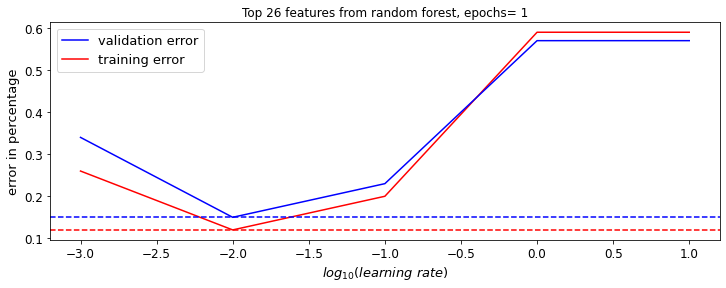

<Figure size 432x288 with 0 Axes>

In [15]:
from pathlib import Path
from matplotlib.pyplot import figure, draw
from matplotlib import pyplot as plt
fn = Path('/Users/mihaithpc/Desktop/svg_figures_dale/lrCNN.svg').expanduser()



draw() # necessary to render figure before saving
fig2.savefig(fn, bbox_inches='tight')






import matplotlib.pyplot as plt
import numpy as np
training = (1-np.array([0.74, 0.88, 0.8, 0.41, 0.41]))*100
validation = (1-np.array([0.66, 0.85, 0.77, 0.43, 0.43]))*100
lr = [-3, -2, -1, 0, 1]

training=np.array(training)
validation=np.array(validation)
fig2 = plt.figure(figsize = (12,4))

training_plot, = plt.plot(lr, training/100, 'r-');
validation_plot, = plt.plot(lr, validation/100, 'b-');
plt.legend([validation_plot, training_plot],["validation error", "training error"], fontsize=13)
plt.axhline(y=min(validation/100), color='b', linestyle='--')
plt.axhline(y=min(training/100), color = 'r', linestyle='--')
plt.xlabel(r"$log_{10}(learning \ rate)$", fontsize=13)
plt.ylabel("error in percentage",fontsize=13)
plt.tick_params(labelsize='large')
plt.title("Top 26 features from random forest, epochs= 1")
plt.show()


draw() # necessary to render figure before saving
fig2.savefig(fn, bbox_inches='tight')

In [12]:
# tune epoch size using learning rate with highest accuracy from before
for epoch in [250]:
    #acc_train = []
    #acc_dev = []
    for i in range(1):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(42, 26)))
        model.add(AveragePooling1D(pool_size=2))
        model.add(Flatten())
        #model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation ='sigmoid'))
        #model.compile(optimizer='adam', loss='mse')
        sgd = SGD(lr = 0.01, momentum = 0.9, decay = 0, nesterov = False)
        model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
        model.fit(new_train, label_train, batch_size = 100, epochs = epoch, verbose = 0)
        #model.summary()

        y_pred_dev = model.predict(new_dev)
        y_pred_dev = np.array(y_pred_dev > 0.5)
        y_pred_dev = y_pred_dev.reshape(y_pred_dev.shape[0])

        y_pred_train = model.predict(new_train)
        y_pred_train = np.array(y_pred_train > 0.5)
        y_pred_train = y_pred_train.reshape(y_pred_train.shape[0])
        
        
        from sklearn import metrics
        acc_dev.append(metrics.accuracy_score(label_dev, y_pred_dev))
        acc_train.append(metrics.accuracy_score(label_train, y_pred_train))
        #print(str(lr)+ ": ")
        print("Accuracy for test:",metrics.accuracy_score(label_dev, y_pred_dev))
        print("Accuracy for train:",metrics.accuracy_score(label_train, y_pred_train))
        print("---")
    

Accuracy for test: 0.9105276574050472
Accuracy for train: 0.975162139964315
---


# Tune epoch size using already tuned learning rate

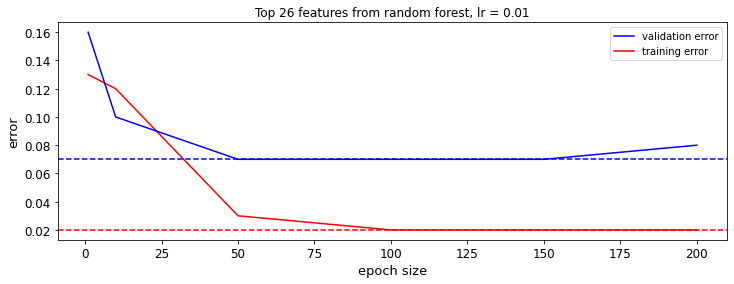

<Figure size 432x288 with 0 Axes>

In [16]:
from pathlib import Path
from matplotlib.pyplot import figure, draw
from matplotlib import pyplot as plt
fn = Path('/Users/mihaithpc/Desktop/svg_figures_dale/epochCNN.svg').expanduser()





training = (1-np.array([0.87, 0.88, 0.97, 0.98, 0.98, 0.98]))*100
validation = (1-np.array([0.84, 0.9, 0.93, 0.93, 0.93, 0.92]))*100
epoch = [1, 10, 50, 100, 150, 200]

fig2 = plt.figure(figsize = (12,4))

training=np.array(training)
validation=np.array(validation)
training_plot, = plt.plot(epoch, training/100, 'r-');
validation_plot, = plt.plot(epoch, validation/100, 'b-');
plt.legend([validation_plot, training_plot],["validation error", "training error"])
plt.axhline(y=min(validation/100), color='b', linestyle='--')
plt.axhline(y=min(training/100), color = 'r', linestyle='--')
plt.xlabel("epoch size", fontsize=13)
plt.ylabel("error", fontsize=13)
plt.tick_params(labelsize='large')
plt.title("Top 26 features from random forest, lr = 0.01")
plt.show()

draw() # necessary to render figure before saving
fig2.savefig(fn, bbox_inches='tight')




In [57]:
# learning curve, plot as proportion of training data used
for proportion in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9,1]:
    acc_train = []
    acc_dev = []
    new_train2 = new_train[:int(proportion*new_train.shape[0])]
    label_train2 = label_train[:int(proportion*label_train.shape[0])]
    for i in range(30):        
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(42, 28)))
        model.add(AveragePooling1D(pool_size=2))
        model.add(Flatten())
        #model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation ='sigmoid'))
        #model.compile(optimizer='adam', loss='mse')
        sgd = SGD(lr = 0.01, momentum = 0.9, decay = 0, nesterov = False)
        model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
        model.fit(new_train2, label_train2, batch_size = 100, epochs = 1, verbose = 0)
        #model.summary()

        y_pred_dev = model.predict(new_dev)
        y_pred_dev = np.array(y_pred_dev > 0.5)
        y_pred_dev = y_pred_dev.reshape(y_pred_dev.shape[0])

        y_pred_train = model.predict(new_train2)
        y_pred_train = np.array(y_pred_train > 0.5)
        y_pred_train = y_pred_train.reshape(y_pred_train.shape[0])
        
        
        from sklearn import metrics
        acc_dev.append(metrics.accuracy_score(label_dev, y_pred_dev))
        acc_train.append(metrics.accuracy_score(label_train2, y_pred_train))
        #print(str(lr)+ ": ")
        #print("Accuracy for test:",metrics.accuracy_score(label_dev, y_pred_dev))
        #print("Accuracy for train:",metrics.accuracy_score(label_train, y_pred_train))
        #print("---")
    print(str(proportion) + ": ")
    print("Train: mean, std: " + str(round(mean(acc_train),2)) + ", " + str(round(statistics.stdev(acc_train),2))) 
    print("Dev: mean, std: " + str(round(mean(acc_dev),2)) + ", " + str(round(statistics.stdev(acc_dev),2)))





0.1: 
Train: mean, std: 0.72, 0.07
Dev: mean, std: 0.61, 0.02
0.2: 
Train: mean, std: 0.84, 0.04
Dev: mean, std: 0.69, 0.05
0.3: 
Train: mean, std: 0.87, 0.01
Dev: mean, std: 0.74, 0.02
0.4: 
Train: mean, std: 0.88, 0.01
Dev: mean, std: 0.77, 0.02
0.5: 
Train: mean, std: 0.88, 0.01
Dev: mean, std: 0.78, 0.02
0.6: 
Train: mean, std: 0.88, 0.01
Dev: mean, std: 0.79, 0.02
0.7: 
Train: mean, std: 0.87, 0.03
Dev: mean, std: 0.8, 0.03
0.8: 
Train: mean, std: 0.88, 0.01
Dev: mean, std: 0.82, 0.01
0.9: 
Train: mean, std: 0.87, 0.01
Dev: mean, std: 0.83, 0.02
1: 
Train: mean, std: 0.87, 0.02
Dev: mean, std: 0.83, 0.02


# See learning curve as function of training data used, but with epoch of size 1 to speed up training. I used the average 30 models for each proportion to get a representative value.

<Figure size 432x288 with 0 Axes>

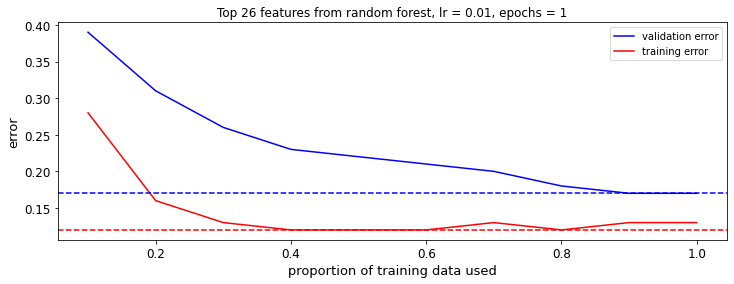

<Figure size 432x288 with 0 Axes>

In [17]:
from pathlib import Path
from matplotlib.pyplot import figure, draw
from matplotlib import pyplot as plt
fn = Path('/Users/mihaithpc/Desktop/svg_figures_dale/lrcurveCNN.svg').expanduser()



draw() # necessary to render figure before saving
fig2.savefig(fn, bbox_inches='tight')







training = (1-np.array([0.72, 0.84, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87]))*100
validation = (1-np.array([0.61, 0.69, 0.74, 0.77, 0.78, 0.79, 0.8, 0.82, 0.83, 0.83]))*100
proportion = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
training=np.array(training)
validation=np.array(validation)
fig2 = plt.figure(figsize = (12,4))

training_plot, = plt.plot(proportion, training/100, 'r-');
validation_plot, = plt.plot(proportion, validation/100, 'b-');
plt.legend([validation_plot, training_plot],["validation error", "training error"])
plt.axhline(y=min(validation/100), color='b', linestyle='--')
plt.axhline(y=min(training/100), color = 'r', linestyle='--')
plt.xlabel("proportion of training data used",fontsize=13)
plt.ylabel("error", fontsize=13)
plt.tick_params(labelsize='large')
plt.title("Top 26 features from random forest, lr = 0.01, epochs = 1")
plt.show()

draw() # necessary to render figure before saving
fig2.savefig(fn, bbox_inches='tight')




# Train different models corresponding to different interval lengths

#### Always choose window size to be the ceil of the corresponding conversion to seconds.

Overlapping accuracy was 86.19%.

The accuracy for predicting intervals of bigger length decreases as the length of the interval increases.
Thus it is not expected that we can a lower accuracy on the aligned plots.

There are too many parameters that appear in all of the models. The models for higher length intervals double in the size of parameters and they also take a lot of time to build. Since the accuracy for using the first three lengths in the segmentation algorithm is smalller, I think this is a good predictor that if we use the lengths up to 0.125, so 10800 seconds, the accuracy will be even smaller. Last but not least, I do not have enough space on my computer to store all the details of all the models. 

I tried to decrease the number of filters I used, increase the size of the stride, hoping that the time it takes is lower; it was lower, but the accuracy was too small to be included in the segmentation algorithm. And these reductions were still not enough for the 685 second model. 

In conclusion, maybe I'm not using the hyperparameters of the models right or there is not enough data to train on. Intuitively, it might be harder to get predictions with larger intervals. Namely, it is much easier to predict windows of length 43 rather than windows of length 685, for example. And the models showed that (according to my choice of hyperparameters - I tried various choices for the number of filters, strides, kernel_size) this is indeed the case. For example, in an instance of the model with windows of size 43, that had an accuracy of 94%, with average 93%, the number of filters chosen was 64; I then changed it to 32 and the accuracy became 93%. Given its stochastic nature, I believe it's just not able to train it better, so 32 filters were just as enough as 64. Like this I tried to increase/decrease size of certain hyperparameters and the model did not increase its accuracy.

In [6]:
for i in [2048, 1024, 512, 256, 128, 64, 32, 16, 8]:
    seconds = (1/i)*24*3600
    print("Precision for " + str(1) + "/" + str(i) + " is: " + str(seconds) + " seconds(timestamps).")

Precision for 1/2048 is: 42.1875 seconds(timestamps).
Precision for 1/1024 is: 84.375 seconds(timestamps).
Precision for 1/512 is: 168.75 seconds(timestamps).
Precision for 1/256 is: 337.5 seconds(timestamps).
Precision for 1/128 is: 675.0 seconds(timestamps).
Precision for 1/64 is: 1350.0 seconds(timestamps).
Precision for 1/32 is: 2700.0 seconds(timestamps).
Precision for 1/16 is: 5400.0 seconds(timestamps).
Precision for 1/8 is: 10800.0 seconds(timestamps).


#### Train different models for windows: 43, 85, 169, 338, 675, 1350, 2700, 5400, 10800 timestamps


In [7]:
windows = [43, 85, 169, 338, 675, 1350, 2700, 5400, 10800]
def model(window):
    precision = 21
    stride = int(window/43)
    new_train = modified_data(precision, window, X_train)
    new_dev = modified_data(precision, window, X_dev)
    label_train = modified_labels(precision, window, y_train)
    label_dev = modified_labels(precision, window, y_dev)
    kernel_size = int(window/10)
    
    print(new_train.shape, label_train.shape)
    print(new_dev.shape, label_dev.shape)
    
    model = Sequential()
    model.add(Conv1D(filters=40, kernel_size=kernel_size, strides = stride, activation='relu', input_shape=(window, 28)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation ='sigmoid'))
    print(model.summary())
    #model.compile(optimizer='adam', loss='mse')
    sgd = SGD(lr = 0.01, momentum = 0.9, decay = 0, nesterov = False)
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    model.fit(new_train, label_train, batch_size = 100, epochs = 150, verbose = 0)
    #model.summary()

    y_pred_dev = model.predict(new_dev)
    y_pred_dev = np.array(y_pred_dev > 0.5)
    y_pred_dev = y_pred_dev.reshape(y_pred_dev.shape[0])

    y_pred_train = model.predict(new_train)
    y_pred_train = np.array(y_pred_train > 0.5)
    y_pred_train = y_pred_train.reshape(y_pred_train.shape[0])
        
        
    from sklearn import metrics
    print(str(window)+ ": ")
    print("Accuracy for test:",metrics.accuracy_score(label_dev, y_pred_dev))
    print("Accuracy for train:",metrics.accuracy_score(label_train, y_pred_train))
    print("---")
    
    return model

        

In [8]:
#windows = [43, 85, 169, 338, 675, 1350, 2700, 5400, 10800]
model2048 = model(43)
model1024 = model(85)

(35309, 43, 28) (35309,)
(11769, 43, 28) (11769,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 40)            4520      
_________________________________________________________________
average_pooling1d_1 (Average (None, 20, 40)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 801       
Total params: 5,321
Trainable params: 5,321
Non-trainable params: 0
_________________________________________________________________
None
43: 
Accuracy for test: 0.9384824539043249
Accuracy for train: 0.976974708997706
---
(35307, 85, 28) (35307,)
(11767, 85, 28) (11767,)
Model: "sequential_2"
______________________________________

In [9]:
%%time
model512 = model(169)
model256 = model(338)
model128 = model(675)
model64 = model(1350)
#model32 = model(2700)
#model16 = model(5400)
#model8 = model(10800)

(35303, 169, 28) (35303,)
(11763, 169, 28) (11763,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 52, 40)            17960     
_________________________________________________________________
average_pooling1d_3 (Average (None, 26, 40)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1040)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1041      
Total params: 19,001
Trainable params: 19,001
Non-trainable params: 0
_________________________________________________________________
None
169: 
Accuracy for test: 0.8876137039870782
Accuracy for train: 0.9719853836784409
---
(35295, 338, 28) (35295,)
(11755, 338, 28) (11755,)
Model: "sequential_4"
______________________________

KeyboardInterrupt: 

In [48]:
modelx = model(43)

(35309, 43, 28) (35309,)
(11769, 43, 28) (11769,)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 39, 128)           18048     
_________________________________________________________________
average_pooling1d_17 (Averag (None, 19, 128)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 2432)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2433      
Total params: 20,481
Trainable params: 20,481
Non-trainable params: 0
_________________________________________________________________
None
43: 
Accuracy for test: 0.9295607103407256
Accuracy for train: 0.9764649239570647
---


In [39]:
print(model2048.summary())
print(model1024.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 64)            7232      
_________________________________________________________________
average_pooling1d_1 (Average (None, 20, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 8,513
Trainable params: 8,513
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 78, 64)            14400     
_________________________

# Do the segmentation using the mapping we have just learned

In [9]:
from pysegments import Interval, segment
import math

base_interval_length = 2.8608
base_interval = Interval(0, base_interval_length)

def in_character(interval):
    precision = 42
    left = interval.inf
    right = interval.sup
    #subInt_length = 1/1024
    print((left, right))
    #print((left,right))
    index_left = int(3600*24*left)
    index_right = math.ceil(3600*24*right)
    
    
    if model.predict(np.array(X_test[index_left:index_left+precision]).reshape(1,precision,26)) < 0.5:
        return False
    
    if model.predict(np.array(X_test[index_right-precision:index_right]).reshape(1,precision,26)) < 0.5:
        return False
    
    for k in range(index_left,index_right-precision, precision):
        if model.predict(np.array(X_test[k:k+precision]).reshape(1,precision,26)) < 0.5:
            return False
        
    return True

In [10]:
#create the intervals, then use them in the notebook called "nice_plots_segmentation"
segment(Interval(0,base_interval_length), in_character, 12, 9)

(0.0, 2.0)
(0.0, 1.0)
(1.0, 2.0)
(2.0, 2.5)
(0.0, 0.5)
(0.5, 1.0)
(1.0, 1.5)
(1.5, 2.0)
(2.5, 2.75)
(2.0, 2.25)
(2.25, 2.5)
(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)
(1.0, 1.25)
(1.25, 1.5)
(1.5, 1.75)
(1.75, 2.0)
(2.5, 2.625)
(2.625, 2.75)
(2.0, 2.125)
(2.125, 2.25)
(2.25, 2.375)
(2.375, 2.5)
(0.0, 0.125)
(0.125, 0.25)
(0.25, 0.375)
(0.375, 0.5)
(0.5, 0.625)
(0.625, 0.75)
(0.75, 0.875)
(0.875, 1.0)
(1.0, 1.125)
(1.125, 1.25)
(1.25, 1.375)
(1.375, 1.5)
(1.5, 1.625)
(1.625, 1.75)
(1.75, 1.875)
(1.875, 2.0)
(2.75, 2.8125)
(2.5, 2.5625)
(2.5625, 2.625)
(2.625, 2.6875)
(2.6875, 2.75)
(2.0, 2.0625)
(2.0625, 2.125)
(2.125, 2.1875)
(2.1875, 2.25)
(2.25, 2.3125)
(2.3125, 2.375)
(2.375, 2.4375)
(2.4375, 2.5)
(0.0, 0.0625)
(0.0625, 0.125)
(0.125, 0.1875)
(0.1875, 0.25)
(0.25, 0.3125)
(0.3125, 0.375)
(0.375, 0.4375)
(0.4375, 0.5)
(0.5, 0.5625)
(0.5625, 0.625)
(0.625, 0.6875)
(0.6875, 0.75)
(0.75, 0.8125)
(0.8125, 0.875)
(0.875, 0.9375)
(0.9375, 1.0)
(1.0, 1.0625)
(1.0625, 1.125)
(1.125, 1.1

(0.15625, 0.1875)
(0.1875, 0.21875)
(0.21875, 0.25)
(0.75, 0.78125)
(0.78125, 0.8125)
(0.25, 0.28125)
(0.28125, 0.3125)
(0.3125, 0.34375)
(0.34375, 0.375)
(0.375, 0.40625)
(0.40625, 0.4375)
(0.4375, 0.46875)
(0.46875, 0.5)
(0.5, 0.53125)
(0.53125, 0.5625)
(0.5625, 0.59375)
(0.59375, 0.625)
(0.625, 0.65625)
(0.65625, 0.6875)
(0.6875, 0.71875)
(0.71875, 0.75)
(0.140625, 0.15625)
(0.8125, 0.828125)
(0.15625, 0.171875)
(0.171875, 0.1875)
(0.1875, 0.203125)
(0.203125, 0.21875)
(0.21875, 0.234375)
(0.234375, 0.25)
(0.21875, 0.25)
(0.2265625, 0.25)
(0.23046875, 0.25)
(0.2265625, 0.25)
(0.228515625, 0.25)
(0.2265625, 0.25)
(0.2275390625, 0.25)
(0.2265625, 0.25)
(0.22705078125, 0.25)
(0.227294921875, 0.25)
(0.22705078125, 0.25)
(0.227294921875, 0.265625)
(0.227294921875, 0.2578125)
(0.227294921875, 0.265625)
(0.227294921875, 0.26171875)
(0.227294921875, 0.259765625)
(0.227294921875, 0.26171875)
(0.227294921875, 0.2607421875)
(0.227294921875, 0.26025390625)
(0.227294921875, 0.260009765625)
(0.15

(0.2890625, 0.29296875)
(0.29296875, 0.296875)
(0.296875, 0.30078125)
(0.30078125, 0.3046875)
(0.3046875, 0.30859375)
(0.30859375, 0.3125)
(0.3046875, 0.3125)
(0.306640625, 0.3125)
(0.3076171875, 0.3125)
(0.30810546875, 0.3125)
(0.308349609375, 0.3125)
(0.30810546875, 0.3125)
(0.308349609375, 0.314453125)
(0.308349609375, 0.3154296875)
(0.308349609375, 0.31494140625)
(0.308349609375, 0.3154296875)
(0.308349609375, 0.315185546875)
(0.28125, 0.296875)
(0.2734375, 0.28125)
(0.296875, 0.3046875)
(0.28125, 0.2890625)
(0.2890625, 0.296875)
(0.2734375, 0.27734375)
(0.27734375, 0.28125)
(0.296875, 0.30078125)
(0.30078125, 0.3046875)
(0.28125, 0.28515625)
(0.28515625, 0.2890625)
(0.2890625, 0.29296875)
(0.29296875, 0.296875)
(0.3046875, 0.306640625)
(0.2734375, 0.275390625)
(0.275390625, 0.27734375)
(0.27734375, 0.279296875)
(0.279296875, 0.28125)
(0.296875, 0.298828125)
(0.298828125, 0.30078125)
(0.30078125, 0.302734375)
(0.302734375, 0.3046875)
(0.28125, 0.283203125)
(0.283203125, 0.28515625)

(0.6875, 0.75)
(0.625, 0.65625)
(0.65625, 0.6875)
(0.6875, 0.71875)
(0.71875, 0.75)
(0.75, 0.765625)
(0.625, 0.640625)
(0.640625, 0.65625)
(0.65625, 0.671875)
(0.640625, 0.671875)
(0.6484375, 0.671875)
(0.640625, 0.671875)
(0.64453125, 0.671875)
(0.646484375, 0.671875)
(0.6474609375, 0.671875)
(0.646484375, 0.671875)
(0.64697265625, 0.671875)
(0.647216796875, 0.671875)
(0.64697265625, 0.671875)
(0.647216796875, 0.6875)
(0.647216796875, 0.6796875)
(0.647216796875, 0.67578125)
(0.647216796875, 0.673828125)
(0.647216796875, 0.67578125)
(0.647216796875, 0.6748046875)
(0.647216796875, 0.67578125)
(0.647216796875, 0.67529296875)
(0.647216796875, 0.67578125)
(0.647216796875, 0.675537109375)
(0.625, 0.640625)
(0.625, 0.6328125)
(0.6328125, 0.640625)
(0.640625, 0.64453125)
(0.625, 0.62890625)
(0.62890625, 0.6328125)
(0.6328125, 0.63671875)
(0.63671875, 0.640625)
(0.64453125, 0.646484375)
(0.640625, 0.642578125)
(0.642578125, 0.64453125)
(0.625, 0.626953125)
(0.626953125, 0.62890625)
(0.62890625

(0.93359375, 0.9375)
(0.90234375, 0.904296875)
(0.904296875, 0.90625)
(0.90625, 0.908203125)
(0.908203125, 0.91015625)
(0.91015625, 0.912109375)
(0.912109375, 0.9140625)
(0.9140625, 0.916015625)
(0.916015625, 0.91796875)
(0.91796875, 0.919921875)
(0.919921875, 0.921875)
(0.921875, 0.923828125)
(0.923828125, 0.92578125)
(0.92578125, 0.927734375)
(0.927734375, 0.9296875)
(0.9296875, 0.931640625)
(0.931640625, 0.93359375)
(0.93359375, 0.935546875)
(0.935546875, 0.9375)
(0.9765625, 0.984375)
(0.984375, 0.9921875)
(0.9921875, 0.99609375)
(0.9765625, 0.98046875)
(0.98046875, 0.984375)
(0.984375, 0.98828125)
(0.98828125, 0.9921875)
(0.99609375, 0.998046875)
(0.9921875, 0.994140625)
(0.994140625, 0.99609375)
(0.9765625, 0.978515625)
(0.978515625, 0.98046875)
(0.98046875, 0.982421875)
(0.982421875, 0.984375)
(0.984375, 0.986328125)
(0.986328125, 0.98828125)
(0.98828125, 0.990234375)
(0.990234375, 0.9921875)
(1.5, 2.0)
(1.25, 1.5)
(1.5, 1.75)
(1.75, 2.0)
(1.125, 1.25)
(1.25, 1.375)
(1.375, 1.5)


(1.22265625, 1.2265625)
(1.205078125, 1.20703125)
(1.2265625, 1.228515625)
(1.20703125, 1.208984375)
(1.208984375, 1.2109375)
(1.2109375, 1.212890625)
(1.212890625, 1.21484375)
(1.21484375, 1.216796875)
(1.216796875, 1.21875)
(1.21875, 1.220703125)
(1.220703125, 1.22265625)
(1.22265625, 1.224609375)
(1.224609375, 1.2265625)
(1.25, 1.375)
(1.25, 1.3125)
(1.3125, 1.375)
(1.25, 1.28125)
(1.28125, 1.3125)
(1.3125, 1.34375)
(1.34375, 1.375)
(1.25, 1.265625)
(1.265625, 1.28125)
(1.28125, 1.296875)
(1.296875, 1.3125)
(1.3125, 1.328125)
(1.328125, 1.34375)
(1.34375, 1.359375)
(1.359375, 1.375)
(1.34375, 1.375)
(1.3515625, 1.375)
(1.35546875, 1.375)
(1.3515625, 1.375)
(1.353515625, 1.375)
(1.3515625, 1.375)
(1.3525390625, 1.375)
(1.3515625, 1.375)
(1.35205078125, 1.375)
(1.3515625, 1.375)
(1.351806640625, 1.375)
(1.35205078125, 1.3828125)
(1.35205078125, 1.37890625)
(1.35205078125, 1.376953125)
(1.35205078125, 1.3759765625)
(1.35205078125, 1.37548828125)
(1.35205078125, 1.3759765625)
(1.3520507

(1.7333984375, 1.76953125)
(1.7333984375, 1.7734375)
(1.7333984375, 1.771484375)
(1.7333984375, 1.7705078125)
(1.7333984375, 1.77001953125)
(1.7333984375, 1.7705078125)
(1.7333984375, 1.770263671875)
(1.7333984375, 1.7705078125)
(1.5, 1.625)
(1.625, 1.6875)
(1.5, 1.5625)
(1.5625, 1.625)
(1.6875, 1.71875)
(1.625, 1.65625)
(1.65625, 1.6875)
(1.5, 1.53125)
(1.53125, 1.5625)
(1.5625, 1.59375)
(1.59375, 1.625)
(1.484375, 1.5)
(1.6875, 1.703125)
(1.703125, 1.71875)
(1.625, 1.640625)
(1.609375, 1.640625)
(1.6171875, 1.640625)
(1.609375, 1.640625)
(1.61328125, 1.640625)
(1.615234375, 1.640625)
(1.61328125, 1.640625)
(1.6142578125, 1.640625)
(1.61474609375, 1.640625)
(1.614990234375, 1.640625)
(1.615234375, 1.65625)
(1.615234375, 1.6484375)
(1.615234375, 1.65625)
(1.615234375, 1.65234375)
(1.615234375, 1.65625)
(1.615234375, 1.654296875)
(1.615234375, 1.6533203125)
(1.615234375, 1.654296875)
(1.615234375, 1.65380859375)
(1.615234375, 1.654296875)
(1.615234375, 1.654052734375)
(1.5, 1.5625)
(1.5

(1.71875, 1.7265625)
(1.65625, 1.6640625)
(1.6640625, 1.671875)
(1.671875, 1.6796875)
(1.6796875, 1.6875)
(1.6875, 1.6953125)
(1.6953125, 1.703125)
(1.703125, 1.7109375)
(1.6953125, 1.7109375)
(1.69921875, 1.7109375)
(1.6953125, 1.7109375)
(1.697265625, 1.7109375)
(1.6982421875, 1.7109375)
(1.697265625, 1.7109375)
(1.69775390625, 1.7109375)
(1.697998046875, 1.7109375)
(1.69775390625, 1.7109375)
(1.697998046875, 1.71875)
(1.697998046875, 1.71484375)
(1.697998046875, 1.712890625)
(1.697998046875, 1.7119140625)
(1.697998046875, 1.71142578125)
(1.697998046875, 1.711181640625)
(1.697998046875, 1.71142578125)
(1.65625, 1.6875)
(1.65625, 1.671875)
(1.671875, 1.6875)
(1.6875, 1.6953125)
(1.65625, 1.6640625)
(1.6640625, 1.671875)
(1.671875, 1.6796875)
(1.6796875, 1.6875)
(1.65234375, 1.65625)
(1.6875, 1.69140625)
(1.68359375, 1.69140625)
(1.685546875, 1.69140625)
(1.68359375, 1.69140625)
(1.6845703125, 1.69140625)
(1.68505859375, 1.69140625)
(1.6845703125, 1.69140625)
(1.684814453125, 1.6914062

(2.00390625, 2.0078125)
(2.0078125, 2.009765625)
(1.98828125, 1.990234375)
(1.990234375, 1.9921875)
(1.9921875, 1.994140625)
(1.994140625, 1.99609375)
(1.99609375, 1.998046875)
(1.998046875, 2.0)
(2.0, 2.001953125)
(2.001953125, 2.00390625)
(2.00390625, 2.005859375)
(2.005859375, 2.0078125)
(2.046875, 2.0625)
(2.0625, 2.078125)
(2.078125, 2.0859375)
(2.046875, 2.0546875)
(2.0546875, 2.0625)
(2.046875, 2.0625)
(2.05078125, 2.0625)
(2.052734375, 2.0625)
(2.0537109375, 2.0625)
(2.052734375, 2.0625)
(2.05322265625, 2.0625)
(2.052734375, 2.0625)
(2.052978515625, 2.0625)
(2.05322265625, 2.0703125)
(2.05322265625, 2.078125)
(2.05322265625, 2.07421875)
(2.05322265625, 2.072265625)
(2.05322265625, 2.0712890625)
(2.05322265625, 2.072265625)
(2.05322265625, 2.07177734375)
(2.05322265625, 2.071533203125)
(2.05322265625, 2.07177734375)
(2.046875, 2.05078125)
(2.044921875, 2.046875)
(2.05078125, 2.052734375)
(2.046875, 2.048828125)
(2.048828125, 2.05078125)
(2.0703125, 2.078125)
(2.078125, 2.0859375

(2.375, 2.390625)
(2.390625, 2.40625)
(2.40625, 2.421875)
(2.421875, 2.4375)
(2.4375, 2.453125)
(2.453125, 2.46875)
(2.46875, 2.484375)
(2.453125, 2.484375)
(2.4609375, 2.484375)
(2.453125, 2.484375)
(2.45703125, 2.484375)
(2.453125, 2.484375)
(2.455078125, 2.484375)
(2.4560546875, 2.484375)
(2.45654296875, 2.484375)
(2.456787109375, 2.484375)
(2.45654296875, 2.484375)
(2.456787109375, 2.5)
(2.456787109375, 2.4921875)
(2.456787109375, 2.48828125)
(2.456787109375, 2.4921875)
(2.456787109375, 2.490234375)
(2.456787109375, 2.4921875)
(2.456787109375, 2.4912109375)
(2.456787109375, 2.4921875)
(2.456787109375, 2.49169921875)
(2.456787109375, 2.491455078125)
(2.456787109375, 2.49169921875)
(2.3125, 2.375)
(2.375, 2.4375)
(2.28125, 2.3125)
(2.3125, 2.34375)
(2.34375, 2.375)
(2.375, 2.40625)
(2.40625, 2.4375)
(2.4375, 2.453125)
(2.28125, 2.296875)
(2.296875, 2.3125)
(2.3125, 2.328125)
(2.328125, 2.34375)
(2.34375, 2.359375)
(2.359375, 2.375)
(2.375, 2.390625)
(2.390625, 2.40625)
(2.40625, 2.42

(2.5625, 2.59375)
(2.59375, 2.625)
(2.625, 2.65625)
(2.65625, 2.6875)
(2.6875, 2.71875)
(2.71875, 2.75)
(2.75, 2.765625)
(2.765625, 2.78125)
(2.78125, 2.796875)
(2.796875, 2.8125)
(2.5, 2.515625)
(2.515625, 2.53125)
(2.53125, 2.546875)
(2.546875, 2.5625)
(2.53125, 2.5625)
(2.5390625, 2.5625)
(2.53125, 2.5625)
(2.53515625, 2.5625)
(2.537109375, 2.5625)
(2.53515625, 2.5625)
(2.5361328125, 2.5625)
(2.53515625, 2.5625)
(2.53564453125, 2.5625)
(2.53515625, 2.5625)
(2.535400390625, 2.5625)
(2.53515625, 2.5625)
(2.535400390625, 2.578125)
(2.535400390625, 2.5703125)
(2.535400390625, 2.578125)
(2.535400390625, 2.57421875)
(2.535400390625, 2.572265625)
(2.535400390625, 2.57421875)
(2.535400390625, 2.5732421875)
(2.535400390625, 2.57421875)
(2.535400390625, 2.57373046875)
(2.535400390625, 2.57421875)
(2.535400390625, 2.573974609375)
(2.5, 2.53125)
(2.5, 2.515625)
(2.515625, 2.53125)
(2.4921875, 2.5)
(2.5, 2.5078125)
(2.4921875, 2.5078125)
(2.49609375, 2.5078125)
(2.498046875, 2.5078125)
(2.499023

(2.724609375, 2.7265625)
(2.734375, 2.736328125)
(2.736328125, 2.73828125)
(2.7265625, 2.728515625)
(2.728515625, 2.73046875)
(2.73046875, 2.732421875)
(2.732421875, 2.734375)
(2.78125, 2.8125)
(2.765625, 2.78125)
(2.78125, 2.796875)
(2.796875, 2.8125)
(2.8125, 2.8203125)
(2.765625, 2.7734375)
(2.7734375, 2.78125)
(2.78125, 2.7890625)
(2.7890625, 2.796875)
(2.796875, 2.8046875)
(2.8046875, 2.8125)
(2.76171875, 2.765625)
(2.8125, 2.81640625)
(2.81640625, 2.8203125)
(2.765625, 2.76953125)
(2.76953125, 2.7734375)
(2.765625, 2.7734375)
(2.767578125, 2.7734375)
(2.765625, 2.7734375)
(2.7666015625, 2.7734375)
(2.76708984375, 2.7734375)
(2.767333984375, 2.7734375)
(2.767578125, 2.77734375)
(2.767578125, 2.78125)
(2.767578125, 2.779296875)
(2.767578125, 2.7783203125)
(2.767578125, 2.779296875)
(2.767578125, 2.77880859375)
(2.767578125, 2.778564453125)
(2.76171875, 2.765625)
(2.759765625, 2.76171875)
(2.765625, 2.767578125)
(2.76171875, 2.763671875)
(2.763671875, 2.765625)
(2.78125, 2.8125)
(2.

[Interval(0.000000, 0.010010),
 Interval(0.029053, 0.066162),
 Interval(0.073486, 0.083252),
 Interval(0.100830, 0.129883),
 Interval(0.130127, 0.136963),
 Interval(0.160156, 0.196045),
 Interval(0.203125, 0.209473),
 Interval(0.227295, 0.259766),
 Interval(0.259766, 0.263672),
 Interval(0.264404, 0.274902),
 Interval(0.308350, 0.314941),
 Interval(0.315430, 0.337402),
 Interval(0.354980, 0.357666),
 Interval(0.359131, 0.371582),
 Interval(0.373779, 0.400635),
 Interval(0.402588, 0.414062),
 Interval(0.433350, 0.466553),
 Interval(0.473389, 0.493408),
 Interval(0.514404, 0.522705),
 Interval(0.523193, 0.552246),
 Interval(0.574707, 0.599121),
 Interval(0.605713, 0.625977),
 Interval(0.647217, 0.675293),
 Interval(0.695557, 0.733398),
 Interval(0.740479, 0.747803),
 Interval(0.766357, 0.797852),
 Interval(0.804688, 0.822266),
 Interval(0.842773, 0.876709),
 Interval(0.883545, 0.886963),
 Interval(0.893555, 0.904053),
 Interval(0.938477, 0.977051),
 Interval(0.999756, 1.034424),
 Interva

,9,4,60,7,10,42,17,5,23,25,...,39,41,44,46,52,54,57,66,89,90
index,,,,,,,,,,,,,,,,,,,,,
1,0.069850,0.147948,0.019818,0.132642,0.393940,0.015668,0.027225,-1.212933,0.241672,0.011980,...,0.011847,0.006672,0.027544,0.037628,-0.052876,0.023713,0.011513,0.040025,-0.015986,-0.013278
2,0.068462,0.145445,0.019088,0.132395,0.390343,0.015965,0.026899,-1.209877,0.240068,0.010484,...,0.011737,0.006865,0.027399,0.037434,-0.052382,0.023770,0.009951,0.039627,-0.015944,-0.013226
3,0.065687,0.142593,0.018429,0.130809,0.386333,0.015375,0.027084,-1.219204,0.240985,0.009980,...,0.011625,0.006273,0.027026,0.036939,-0.051713,0.023331,0.007554,0.039113,-0.016041,-0.013273
4,0.067156,0.153741,0.018093,0.132568,0.390667,0.015867,0.027786,-1.211337,0.242409,0.010972,...,0.011739,0.007061,0.027407,0.037519,-0.052346,0.023951,0.008941,0.039709,-0.015966,-0.013253
5,0.067849,0.148774,0.019356,0.132840,0.392871,0.015766,0.026947,-1.218867,0.241532,0.012250,...,0.011770,0.006638,0.027524,0.037677,-0.052780,0.023733,0.010258,0.039909,-0.016062,-0.013325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235867,0.018634,0.174019,0.003787,0.078728,0.234424,0.006724,0.029103,-1.051046,0.227175,0.016077,...,0.006575,0.004769,0.016199,0.022979,-0.031374,0.014264,0.002054,0.024381,-0.013766,-0.011775
1235868,0.035582,-0.488666,0.026538,-0.000977,0.455604,-0.016037,0.029069,-0.679476,-0.048826,-0.220674,...,-0.003086,0.003229,0.017676,-0.034734,-0.002132,0.026304,0.044554,0.071991,0.000653,-0.001918
1235869,0.018058,0.177109,0.003368,0.077823,0.231478,0.006736,0.029144,-1.048477,0.227254,0.016824,...,0.006477,0.004887,0.016002,0.022701,-0.031055,0.014190,0.001622,0.024087,-0.013748,-0.011760


In [37]:
statistics.stdev([1,2,3,4,5,6,7])

2.160246899469287

In [50]:
new_train.shape

(35309, 42, 28)

In [56]:
new_train.shape

(35309, 42, 28)

In [13]:
from pysegments import Interval, segment
import math

base_interval_length = 2.8608
base_interval = Interval(0, base_interval_length)

def in_character(interval):
    
    left = interval.inf
    right = interval.sup
    #subInt_length = 1/1024
    print((left, right))
    #print((left,right))
    index_left = int(3600*24*left)
    index_right = math.ceil(3600*24*right)
    
    if index_right - index_left >= 169:
        precision = 169
        
        model = model512
    
        if model.predict(np.array(X_test[index_left:index_left+precision]).reshape(1,precision,28)) < 0.5:
            return False

        if model.predict(np.array(X_test[index_right-precision:index_right]).reshape(1,precision,28)) < 0.5:
            return False

        for k in range(index_left,index_right-precision, precision):
            if model.predict(np.array(X_test[k:k+precision]).reshape(1,precision,28)) < 0.5:
                return False
    elif index_right - index_left >= 85:
        precision = 85
        
        model = model1024
        
        if model.predict(np.array(X_test[index_left:index_left+precision]).reshape(1,precision,28)) < 0.5:
            return False

        if model.predict(np.array(X_test[index_right-precision:index_right]).reshape(1,precision,28)) < 0.5:
            return False

        for k in range(index_left,index_right-precision, precision):
            if model.predict(np.array(X_test[k:k+precision]).reshape(1,precision,28)) < 0.5:
                return False
    else:
        precision = 43
        model = model2048
        
        if model.predict(np.array(X_test[index_left:index_left+precision]).reshape(1,precision,28)) < 0.5:
            return False

        if model.predict(np.array(X_test[index_right-precision:index_right]).reshape(1,precision,28)) < 0.5:
            return False

        for k in range(index_left,index_right-precision, precision):
            if model.predict(np.array(X_test[k:k+precision]).reshape(1,precision,28)) < 0.5:
                return False
        
        
    return True

In [14]:
segment(Interval(0,base_interval_length), in_character, 12, 9)

(0.0, 2.0)
(0.0, 1.0)
(1.0, 2.0)
(2.0, 2.5)
(0.0, 0.5)
(0.5, 1.0)
(1.0, 1.5)
(1.5, 2.0)
(2.5, 2.75)
(2.0, 2.25)
(2.25, 2.5)
(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)
(1.0, 1.25)
(1.25, 1.5)
(1.5, 1.75)
(1.75, 2.0)
(2.5, 2.625)
(2.625, 2.75)
(2.0, 2.125)
(2.125, 2.25)
(2.25, 2.375)
(2.375, 2.5)
(0.0, 0.125)
(0.125, 0.25)
(0.25, 0.375)
(0.375, 0.5)
(0.5, 0.625)
(0.625, 0.75)
(0.75, 0.875)
(0.875, 1.0)
(1.0, 1.125)
(1.125, 1.25)
(1.25, 1.375)
(1.375, 1.5)
(1.5, 1.625)
(1.625, 1.75)
(1.75, 1.875)
(1.875, 2.0)
(2.75, 2.8125)
(2.5, 2.5625)
(2.5625, 2.625)
(2.625, 2.6875)
(2.6875, 2.75)
(2.0, 2.0625)
(2.0625, 2.125)
(2.125, 2.1875)
(2.1875, 2.25)
(2.25, 2.3125)
(2.3125, 2.375)
(2.375, 2.4375)
(2.4375, 2.5)
(0.0, 0.0625)
(0.0625, 0.125)
(0.125, 0.1875)
(0.1875, 0.25)
(0.25, 0.3125)
(0.3125, 0.375)
(0.375, 0.4375)
(0.4375, 0.5)
(0.5, 0.5625)
(0.5625, 0.625)
(0.625, 0.6875)
(0.6875, 0.75)
(0.75, 0.8125)
(0.8125, 0.875)
(0.875, 0.9375)
(0.9375, 1.0)
(1.0, 1.0625)
(1.0625, 1.125)
(1.125, 1.1

(0.100830078125, 0.12890625)
(0.100830078125, 0.1328125)
(0.100830078125, 0.130859375)
(0.100830078125, 0.1298828125)
(0.100830078125, 0.130859375)
(0.100830078125, 0.13037109375)
(0.100830078125, 0.130126953125)
(0.078125, 0.09375)
(0.0703125, 0.078125)
(0.078125, 0.0859375)
(0.0859375, 0.09375)
(0.06640625, 0.0703125)
(0.09375, 0.09765625)
(0.0703125, 0.07421875)
(0.07421875, 0.078125)
(0.0703125, 0.078125)
(0.072265625, 0.078125)
(0.0732421875, 0.078125)
(0.072265625, 0.078125)
(0.07275390625, 0.078125)
(0.072998046875, 0.078125)
(0.0732421875, 0.08203125)
(0.0732421875, 0.0859375)
(0.0732421875, 0.083984375)
(0.0732421875, 0.0830078125)
(0.0732421875, 0.083984375)
(0.0732421875, 0.08349609375)
(0.0732421875, 0.083984375)
(0.0732421875, 0.083740234375)
(0.06640625, 0.0703125)
(0.0703125, 0.072265625)
(0.06640625, 0.068359375)
(0.068359375, 0.0703125)
(0.0859375, 0.09375)
(0.08203125, 0.0859375)
(0.09375, 0.09765625)
(0.0859375, 0.08984375)
(0.08984375, 0.09375)
(0.09765625, 0.099609

(0.359375, 0.375)
(0.75, 0.765625)
(0.765625, 0.78125)
(0.75, 0.78125)
(0.7578125, 0.78125)
(0.76171875, 0.78125)
(0.763671875, 0.78125)
(0.7646484375, 0.78125)
(0.76513671875, 0.78125)
(0.765380859375, 0.78125)
(0.765625, 0.796875)
(0.765625, 0.8125)
(0.765625, 0.8046875)
(0.765625, 0.80078125)
(0.765625, 0.798828125)
(0.765625, 0.80078125)
(0.765625, 0.7998046875)
(0.765625, 0.79931640625)
(0.765625, 0.799072265625)
(0.5, 0.75)
(0.375, 0.5)
(0.5, 0.625)
(0.625, 0.75)
(0.375, 0.4375)
(0.4375, 0.5)
(0.5, 0.5625)
(0.5625, 0.625)
(0.625, 0.6875)
(0.6875, 0.75)
(0.34375, 0.375)
(0.375, 0.40625)
(0.40625, 0.4375)
(0.4375, 0.46875)
(0.46875, 0.5)
(0.5, 0.53125)
(0.53125, 0.5625)
(0.5625, 0.59375)
(0.59375, 0.625)
(0.625, 0.65625)
(0.65625, 0.6875)
(0.6875, 0.71875)
(0.71875, 0.75)
(0.75, 0.765625)
(0.34375, 0.359375)
(0.359375, 0.375)
(0.375, 0.390625)
(0.390625, 0.40625)
(0.375, 0.40625)
(0.3828125, 0.40625)
(0.375, 0.40625)
(0.37890625, 0.40625)
(0.375, 0.40625)
(0.376953125, 0.40625)
(0.

(0.60302734375, 0.6259765625)
(0.60302734375, 0.626953125)
(0.60302734375, 0.62646484375)
(0.60302734375, 0.626953125)
(0.60302734375, 0.626708984375)
(0.599609375, 0.6015625)
(0.625, 0.75)
(0.625, 0.6875)
(0.6875, 0.75)
(0.625, 0.65625)
(0.65625, 0.6875)
(0.6875, 0.71875)
(0.71875, 0.75)
(0.75, 0.765625)
(0.625, 0.640625)
(0.640625, 0.65625)
(0.65625, 0.671875)
(0.640625, 0.671875)
(0.6484375, 0.671875)
(0.640625, 0.671875)
(0.64453125, 0.671875)
(0.646484375, 0.671875)
(0.6474609375, 0.671875)
(0.64794921875, 0.671875)
(0.648193359375, 0.671875)
(0.64794921875, 0.671875)
(0.648193359375, 0.6875)
(0.648193359375, 0.6796875)
(0.648193359375, 0.67578125)
(0.648193359375, 0.6796875)
(0.648193359375, 0.677734375)
(0.648193359375, 0.6767578125)
(0.648193359375, 0.67626953125)
(0.648193359375, 0.6767578125)
(0.648193359375, 0.676513671875)
(0.648193359375, 0.6767578125)
(0.625, 0.640625)
(0.625, 0.6328125)
(0.6328125, 0.640625)
(0.640625, 0.64453125)
(0.625, 0.62890625)
(0.625, 0.6328125)
(

(0.9765625, 0.984375)
(0.984375, 0.9921875)
(0.9921875, 0.99609375)
(0.9765625, 0.98046875)
(0.98046875, 0.984375)
(0.984375, 0.98828125)
(0.98828125, 0.9921875)
(0.99609375, 0.998046875)
(0.9921875, 0.994140625)
(0.994140625, 0.99609375)
(0.9765625, 0.978515625)
(0.978515625, 0.98046875)
(0.98046875, 0.982421875)
(0.982421875, 0.984375)
(0.984375, 0.986328125)
(0.986328125, 0.98828125)
(0.98828125, 0.990234375)
(0.990234375, 0.9921875)
(1.5, 2.0)
(1.25, 1.5)
(1.5, 1.75)
(1.75, 2.0)
(1.125, 1.25)
(1.25, 1.375)
(1.375, 1.5)
(1.5, 1.625)
(1.625, 1.75)
(1.75, 1.875)
(1.875, 2.0)
(1.0625, 1.125)
(2.0, 2.0625)
(1.125, 1.1875)
(1.1875, 1.25)
(1.25, 1.3125)
(1.3125, 1.375)
(1.375, 1.4375)
(1.4375, 1.5)
(1.5, 1.5625)
(1.5625, 1.625)
(1.625, 1.6875)
(1.6875, 1.75)
(1.75, 1.8125)
(1.8125, 1.875)
(1.875, 1.9375)
(1.9375, 2.0)
(1.0625, 1.09375)
(1.09375, 1.125)
(2.0, 2.03125)
(2.03125, 2.0625)
(1.125, 1.15625)
(1.15625, 1.1875)
(1.1875, 1.21875)
(1.21875, 1.25)
(1.25, 1.28125)
(1.28125, 1.3125)
(1

(1.328125, 1.34375)
(1.34375, 1.359375)
(1.359375, 1.375)
(1.34375, 1.375)
(1.3515625, 1.375)
(1.35546875, 1.375)
(1.3515625, 1.375)
(1.353515625, 1.375)
(1.3515625, 1.375)
(1.3525390625, 1.375)
(1.3515625, 1.375)
(1.35205078125, 1.375)
(1.3515625, 1.375)
(1.351806640625, 1.375)
(1.35205078125, 1.3828125)
(1.35205078125, 1.37890625)
(1.35205078125, 1.376953125)
(1.35205078125, 1.3759765625)
(1.35205078125, 1.376953125)
(1.35205078125, 1.37646484375)
(1.35205078125, 1.376220703125)
(1.28125, 1.3125)
(1.3125, 1.34375)
(1.265625, 1.28125)
(1.28125, 1.296875)
(1.296875, 1.3125)
(1.3125, 1.328125)
(1.328125, 1.34375)
(1.34375, 1.3515625)
(1.265625, 1.2734375)
(1.2734375, 1.28125)
(1.26953125, 1.28125)
(1.271484375, 1.28125)
(1.2724609375, 1.28125)
(1.271484375, 1.28125)
(1.27197265625, 1.28125)
(1.272216796875, 1.28125)
(1.2724609375, 1.2890625)
(1.2724609375, 1.28515625)
(1.2724609375, 1.283203125)
(1.2724609375, 1.28515625)
(1.2724609375, 1.2841796875)
(1.2724609375, 1.28515625)
(1.272460

(1.511474609375, 1.516845703125)
(1.511474609375, 1.51708984375)
(1.4921875, 1.5)
(1.5, 1.5078125)
(1.48828125, 1.4921875)
(1.4921875, 1.49609375)
(1.49609375, 1.5)
(1.5, 1.50390625)
(1.50390625, 1.5078125)
(1.5078125, 1.509765625)
(1.48828125, 1.490234375)
(1.490234375, 1.4921875)
(1.4921875, 1.494140625)
(1.494140625, 1.49609375)
(1.49609375, 1.498046875)
(1.498046875, 1.5)
(1.49609375, 1.5)
(1.4970703125, 1.5)
(1.49755859375, 1.5)
(1.4970703125, 1.5)
(1.497314453125, 1.5)
(1.49755859375, 1.501953125)
(1.49755859375, 1.50390625)
(1.49755859375, 1.5029296875)
(1.49755859375, 1.50390625)
(1.49755859375, 1.50341796875)
(1.49755859375, 1.503173828125)
(1.48828125, 1.4921875)
(1.4921875, 1.49609375)
(1.48828125, 1.490234375)
(1.490234375, 1.4921875)
(1.4921875, 1.494140625)
(1.494140625, 1.49609375)
(1.50390625, 1.5078125)
(1.501953125, 1.50390625)
(1.5078125, 1.509765625)
(1.50390625, 1.505859375)
(1.505859375, 1.5078125)
(1.53125, 1.5625)
(1.515625, 1.53125)
(1.53125, 1.546875)
(1.54687

(1.66015625, 1.66796875)
(1.662109375, 1.66796875)
(1.66015625, 1.66796875)
(1.6611328125, 1.66796875)
(1.66162109375, 1.66796875)
(1.661865234375, 1.66796875)
(1.662109375, 1.671875)
(1.662109375, 1.669921875)
(1.662109375, 1.6689453125)
(1.662109375, 1.669921875)
(1.662109375, 1.66943359375)
(1.662109375, 1.669189453125)
(1.65625, 1.66015625)
(1.66015625, 1.662109375)
(1.65625, 1.658203125)
(1.65625, 1.66015625)
(1.65625, 1.6591796875)
(1.65625, 1.65869140625)
(1.65625, 1.6591796875)
(1.65625, 1.658935546875)
(1.658203125, 1.66015625)
(1.66015625, 1.662109375)
(1.66796875, 1.671875)
(1.66796875, 1.669921875)
(1.669921875, 1.671875)
(1.681640625, 1.68359375)
(1.703125, 1.71875)
(1.6953125, 1.703125)
(1.71875, 1.7265625)
(1.703125, 1.7109375)
(1.6953125, 1.7109375)
(1.69921875, 1.7109375)
(1.701171875, 1.7109375)
(1.69921875, 1.7109375)
(1.7001953125, 1.7109375)
(1.69921875, 1.7109375)
(1.69970703125, 1.7109375)
(1.69921875, 1.7109375)
(1.699462890625, 1.7109375)
(1.69921875, 1.7109375

(2.00390625, 2.005859375)
(2.005859375, 2.0078125)
(2.046875, 2.0625)
(2.0625, 2.078125)
(2.078125, 2.0859375)
(2.046875, 2.0546875)
(2.0546875, 2.0625)
(2.046875, 2.0625)
(2.05078125, 2.0625)
(2.052734375, 2.0625)
(2.0537109375, 2.0625)
(2.052734375, 2.0625)
(2.05322265625, 2.0625)
(2.052734375, 2.0625)
(2.052978515625, 2.0625)
(2.052734375, 2.0625)
(2.052978515625, 2.0703125)
(2.052978515625, 2.078125)
(2.052978515625, 2.07421875)
(2.052978515625, 2.072265625)
(2.052978515625, 2.0712890625)
(2.052978515625, 2.072265625)
(2.052978515625, 2.07177734375)
(2.052978515625, 2.071533203125)
(2.052978515625, 2.07177734375)
(2.046875, 2.05078125)
(2.044921875, 2.046875)
(2.05078125, 2.052734375)
(2.046875, 2.048828125)
(2.048828125, 2.05078125)
(2.0703125, 2.078125)
(2.078125, 2.0859375)
(2.0859375, 2.08984375)
(2.0703125, 2.07421875)
(2.07421875, 2.078125)
(2.078125, 2.08203125)
(2.08203125, 2.0859375)
(2.08984375, 2.091796875)
(2.0859375, 2.087890625)
(2.087890625, 2.08984375)
(2.0703125, 2

(2.28125, 2.296875)
(2.28515625, 2.296875)
(2.28125, 2.296875)
(2.283203125, 2.296875)
(2.2841796875, 2.296875)
(2.283203125, 2.296875)
(2.28369140625, 2.296875)
(2.283935546875, 2.296875)
(2.2841796875, 2.3046875)
(2.2841796875, 2.30078125)
(2.2841796875, 2.298828125)
(2.2841796875, 2.30078125)
(2.2841796875, 2.2998046875)
(2.2841796875, 2.29931640625)
(2.2841796875, 2.299072265625)
(2.27734375, 2.28125)
(2.28125, 2.283203125)
(2.27734375, 2.279296875)
(2.279296875, 2.28125)
(2.3046875, 2.3125)
(2.30078125, 2.3125)
(2.302734375, 2.3125)
(2.3037109375, 2.3125)
(2.30419921875, 2.3125)
(2.304443359375, 2.3125)
(2.3046875, 2.3134765625)
(2.3046875, 2.31396484375)
(2.3046875, 2.314208984375)
(2.30078125, 2.3046875)
(2.298828125, 2.30078125)
(2.30078125, 2.302734375)
(2.298828125, 2.302734375)
(2.2998046875, 2.302734375)
(2.30029296875, 2.302734375)
(2.300537109375, 2.302734375)
(2.30078125, 2.3046875)
(2.30078125, 2.3037109375)
(2.30078125, 2.30322265625)
(2.30078125, 2.302978515625)
(2.29

(2.5625, 2.625)
(2.75, 2.8125)
(2.625, 2.6875)
(2.6875, 2.75)
(2.53125, 2.5625)
(2.5625, 2.59375)
(2.59375, 2.625)
(2.75, 2.78125)
(2.78125, 2.8125)
(2.625, 2.65625)
(2.65625, 2.6875)
(2.6875, 2.71875)
(2.71875, 2.75)
(2.515625, 2.53125)
(2.53125, 2.546875)
(2.546875, 2.5625)
(2.53125, 2.5625)
(2.5390625, 2.5625)
(2.53125, 2.5625)
(2.53515625, 2.5625)
(2.53125, 2.5625)
(2.533203125, 2.5625)
(2.5341796875, 2.5625)
(2.53466796875, 2.5625)
(2.5341796875, 2.5625)
(2.534423828125, 2.5625)
(2.53466796875, 2.578125)
(2.53466796875, 2.5703125)
(2.53466796875, 2.578125)
(2.53466796875, 2.57421875)
(2.53466796875, 2.578125)
(2.53466796875, 2.576171875)
(2.53466796875, 2.5751953125)
(2.53466796875, 2.576171875)
(2.53466796875, 2.57568359375)
(2.53466796875, 2.576171875)
(2.53466796875, 2.575927734375)
(2.515625, 2.53125)
(2.515625, 2.5234375)
(2.5234375, 2.53125)
(2.515625, 2.51953125)
(2.51953125, 2.5234375)
(2.5234375, 2.52734375)
(2.52734375, 2.53125)
(2.53125, 2.533203125)
(2.515625, 2.517578

(2.7890625, 2.796875)
(2.796875, 2.8046875)
(2.8046875, 2.8125)
(2.78125, 2.78515625)
(2.78515625, 2.7890625)
(2.7890625, 2.79296875)
(2.79296875, 2.796875)
(2.796875, 2.80078125)
(2.80078125, 2.8046875)
(2.796875, 2.8046875)
(2.798828125, 2.8046875)
(2.7998046875, 2.8046875)
(2.798828125, 2.8046875)
(2.79931640625, 2.8046875)
(2.799560546875, 2.8046875)
(2.79931640625, 2.8046875)
(2.799560546875, 2.80859375)
(2.799560546875, 2.8125)
(2.799560546875, 2.810546875)
(2.799560546875, 2.8125)
(2.799560546875, 2.8115234375)
(2.799560546875, 2.8125)
(2.799560546875, 2.81201171875)
(2.799560546875, 2.8125)
(2.799560546875, 2.812255859375)
(2.78125, 2.796875)
(2.78125, 2.7890625)
(2.7890625, 2.796875)
(2.78125, 2.78515625)
(2.78515625, 2.7890625)
(2.7890625, 2.79296875)
(2.79296875, 2.796875)
(2.779296875, 2.78125)
(2.796875, 2.798828125)
(2.78125, 2.783203125)
(2.783203125, 2.78515625)
(2.78515625, 2.787109375)
(2.787109375, 2.7890625)
(2.78515625, 2.7890625)
(2.7861328125, 2.7890625)
(2.78515

[Interval(0.000000, 0.010010),
 Interval(0.029053, 0.066895),
 Interval(0.073242, 0.083496),
 Interval(0.100830, 0.129883),
 Interval(0.130371, 0.136963),
 Interval(0.159668, 0.197510),
 Interval(0.202881, 0.209717),
 Interval(0.227295, 0.259521),
 Interval(0.262451, 0.274902),
 Interval(0.308105, 0.339844),
 Interval(0.356445, 0.359375),
 Interval(0.359863, 0.372314),
 Interval(0.374756, 0.376953),
 Interval(0.376953, 0.415283),
 Interval(0.433105, 0.466553),
 Interval(0.473145, 0.494141),
 Interval(0.514160, 0.556641),
 Interval(0.562500, 0.565430),
 Interval(0.565674, 0.570312),
 Interval(0.570801, 0.600342),
 Interval(0.603027, 0.626465),
 Interval(0.625000, 0.628906),
 Interval(0.648193, 0.676514),
 Interval(0.694092, 0.734619),
 Interval(0.739990, 0.749268),
 Interval(0.765625, 0.798828),
 Interval(0.803955, 0.824219),
 Interval(0.841064, 0.878418),
 Interval(0.881836, 0.888428),
 Interval(0.892090, 0.905518),
 Interval(0.938232, 0.977051),
 Interval(0.999268, 1.035400),
 Interva

In [7]:
for kernel in [3,4,5,6,7,8,9]:
    acc_train = []
    acc_dev = []
    for i in range(5):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=kernel, activation='relu', input_shape=(42, 26)))
        model.add(AveragePooling1D(pool_size=2))
        model.add(Flatten())
        #model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation ='sigmoid'))
        #model.compile(optimizer='adam', loss='mse')
        sgd = SGD(lr = 0.01, momentum = 0.9, decay = 0, nesterov = False)
        model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
        model.fit(new_train, label_train, batch_size = 100, epochs = 1, verbose = 0)
        #model.summary()

        y_pred_dev = model.predict(new_dev)
        y_pred_dev = np.array(y_pred_dev > 0.5)
        y_pred_dev = y_pred_dev.reshape(y_pred_dev.shape[0])

        y_pred_train = model.predict(new_train)
        y_pred_train = np.array(y_pred_train > 0.5)
        y_pred_train = y_pred_train.reshape(y_pred_train.shape[0])
        
        
        from sklearn import metrics
        acc_dev.append(metrics.accuracy_score(label_dev, y_pred_dev))
        acc_train.append(metrics.accuracy_score(label_train, y_pred_train))
        #print(str(lr)+ ": ")
        #print("Accuracy for test:",metrics.accuracy_score(label_dev, y_pred_dev))
        #print("Accuracy for train:",metrics.accuracy_score(label_train, y_pred_train))
        #print("---")
    print(str(kernel) + ": ")
    print("Train: mean, std: " + str(round(mean(acc_train),2)) + ", " + str(round(statistics.stdev(acc_train),2))) 
    print("Dev: mean, std: " + str(round(mean(acc_dev),2)) + ", " + str(round(statistics.stdev(acc_dev),2)))



3: 
Train: mean, std: 0.87, 0.01
Dev: mean, std: 0.83, 0.01
4: 
Train: mean, std: 0.87, 0.01
Dev: mean, std: 0.83, 0.03
5: 
Train: mean, std: 0.87, 0.02
Dev: mean, std: 0.83, 0.03
6: 
Train: mean, std: 0.88, 0.01
Dev: mean, std: 0.84, 0.02
7: 
Train: mean, std: 0.87, 0.01
Dev: mean, std: 0.85, 0.01
8: 
Train: mean, std: 0.86, 0.03
Dev: mean, std: 0.82, 0.03
9: 
Train: mean, std: 0.85, 0.04
Dev: mean, std: 0.82, 0.06


In [ ]:
for kernel in [7]:
    acc_train = []
    acc_dev = []
    for i in range(5):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=kernel, activation='relu', input_shape=(42, 26)))
        model.add(AveragePooling1D(pool_size=2))
        model.add(Flatten())
        #model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation ='sigmoid'))
        #model.compile(optimizer='adam', loss='mse')
        sgd = SGD(lr = 0.01, momentum = 0.9, decay = 0, nesterov = False)
        model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
        model.fit(new_train, label_train, batch_size = 100, epochs = 150, verbose = 0)
        #model.summary()

        y_pred_dev = model.predict(new_dev)
        y_pred_dev = np.array(y_pred_dev > 0.5)
        y_pred_dev = y_pred_dev.reshape(y_pred_dev.shape[0])

        y_pred_train = model.predict(new_train)
        y_pred_train = np.array(y_pred_train > 0.5)
        y_pred_train = y_pred_train.reshape(y_pred_train.shape[0])
        
        
        from sklearn import metrics
        acc_dev.append(metrics.accuracy_score(label_dev, y_pred_dev))
        acc_train.append(metrics.accuracy_score(label_train, y_pred_train))
        #print(str(lr)+ ": ")
        #print("Accuracy for test:",metrics.accuracy_score(label_dev, y_pred_dev))
        #print("Accuracy for train:",metrics.accuracy_score(label_train, y_pred_train))
        #print("---")
    print(str(kernel) + ": ")
    print("Train: mean, std: " + str(round(mean(acc_train),2)) + ", " + str(round(statistics.stdev(acc_train),2))) 
    print("Dev: mean, std: " + str(round(mean(acc_dev),2)) + ", " + str(round(statistics.stdev(acc_dev),2)))




In [ ]:
X_train

In [10]:
new_train/100

array([[[ 6.98501894e-04,  1.47948033e-03,  1.98176788e-04, ...,
          2.37125745e-04,  1.15131686e-04,  4.00250968e-04],
        [ 6.84619910e-04,  1.45445460e-03,  1.90876537e-04, ...,
          2.37704042e-04,  9.95079785e-05,  3.96266702e-04],
        [ 6.56869266e-04,  1.42592808e-03,  1.84289588e-04, ...,
          2.33312989e-04,  7.55379209e-05,  3.91128044e-04],
        ...,
        [ 6.79629789e-04,  1.49417708e-03,  1.68301895e-04, ...,
          2.42622507e-04,  7.85591207e-05,  4.00161004e-04],
        [ 6.59907022e-04,  1.48582720e-03,  1.70461267e-04, ...,
          2.38425464e-04,  7.11777859e-05,  3.95075845e-04],
        [ 5.51102833e-04,  1.42217617e-03,  1.60488323e-04, ...,
          2.45027531e-04,  1.70718907e-05,  4.07561294e-04]],

       [[ 6.45350886e-04,  1.54104053e-03,  1.64766486e-04, ...,
          2.41125198e-04,  6.58796626e-05,  3.96179183e-04],
        [ 6.58986821e-04,  1.53299858e-03,  1.77175179e-04, ...,
          2.39885809e-04,  7.69990275e

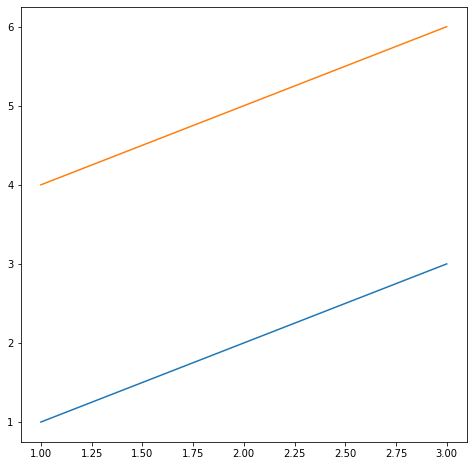

In [6]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(8,8))
plt.plot((1,2,3),(1,2,3))
plt.plot((1,2,3),(4,5,6))
plt.show()

<Figure size 432x288 with 0 Axes>

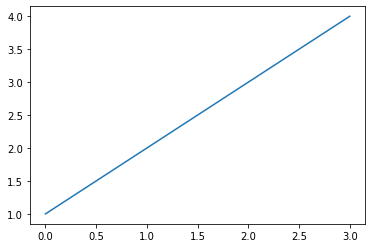

In [14]:
from pathlib import Path
from matplotlib.pyplot import figure, draw
from matplotlib import pyplot as plt
fn = Path('~/Desktop').expanduser()


fg = figure()
data = [1,2,3,4]

fg = figure()
plt.plot(data)


draw() # necessary to render figure before saving
fg.savefig(fn, bbox_inches='tight')